This notebook explores examples and demonstrates creation and visualization of computational graphs. We also leverage automatic differentiation of TensorFlow to capture known physics equations with derivatives.  

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

# Constructing computational graph in a TensorFlow session

In [2]:
mdl1 = tf.Graph()

with mdl1.as_default():
    a = tf.placeholder(tf.float32, name="a")
    b = tf.multiply(2.0, a, name="b")
    c = tf.add(a, b, name="c")

# Intialize the Session
sess_1 = tf.Session(graph=mdl1)   

# Initialize writer
writer = tf.summary.FileWriter("./log/example/1", sess_1.graph)

# Close the writer
writer.close()

# Close the session
sess_1.close()

Note that these codes weere put manually, but eventually a transalator will create tthese codes from the semantic knowledge graphs. The attribute of name of the variable will be made consistent with those from the knowledge graphs.

The graph constructed by the above TensorFlow session can be visualized in TensorBoard. One can open TensorBoard as follows:

Type the following in cmd prompt:

    tensorboard --logdir="./log/example"

The resulting computational graph is available under Graph tab of TensorBoard or by going to http://localhost:6006/#graphs
in your browser after running TensorBoard:

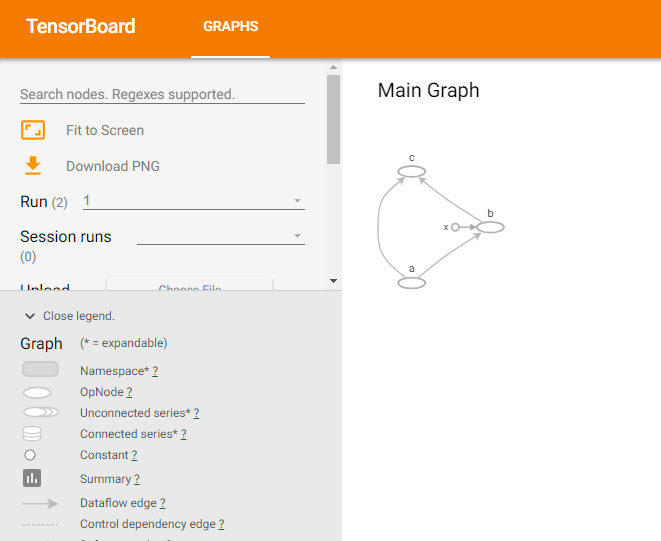

As shown in the above figure the computational graph depicted by the above code is as follows:

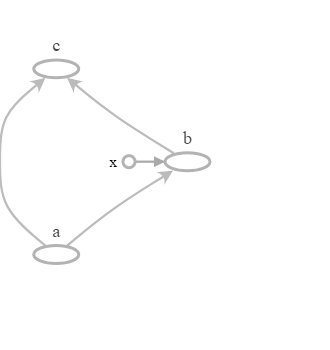

# Constructing computational graph with symbolic derivative in a TensorFlow session

For the ScientificConcept of Derivative from the semantic model, we plan to add a symbolic derivative using tf.gradients which will be incorporated in the tensorFlow computational graph.

The definition of Derivative as a ScientificConcept in semantic modelo is given here:

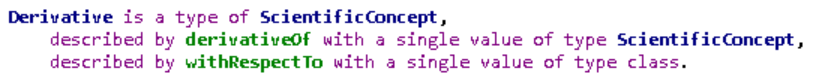

As an example, we show the definition of ScientificConcept of Velocity
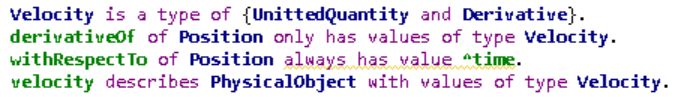

The Derivative is encoded in graph model using tf.gradients for Velocity example as follows:
```
Velocity = tf.gradients(Position, [time], stop_gradients=[time],name="Velocity")
```

In general, we can use the followwing during translation:
```
Output ScientificConcept = tf.gradients(derivativeOf ScientificConcept, [withRespectTo class], stop_gradients=[withRespectTo class],name="Output")
```

We show a TensorFlow code and the resulting computational graph with example 1 and the symbolic derivative:

In [3]:
mdl2 = tf.Graph()
with mdl2.as_default():
    a = tf.placeholder(tf.float32, name="a")
    d = tf.constant(2.0)
    b = tf.multiply(d, a, name="b")
    c = tf.add(a, b, name="c")
    g = tf.gradients(c, [a], stop_gradients=[a],name="g")

# Intialize the Session
sess_2 = tf.Session(graph=mdl2)

# Initialize writer
writer = tf.summary.FileWriter("./log/example/2", sess_2.graph)

# Close the writer
writer.close()

# Close the session
sess_2.close()

The computational graph depicted by the above code as visualized by TensorBoard is as follows:

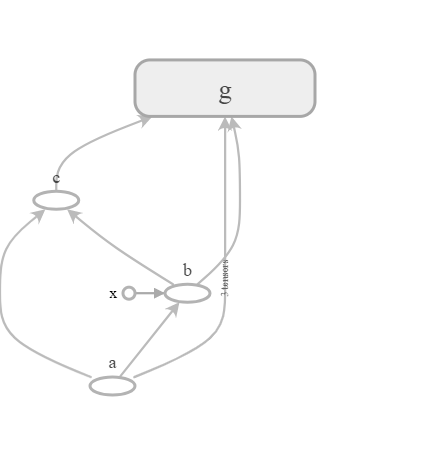

# Creating knowledge-consistent graph models in chosen domain 

When exact knowledge of relationships via equations is available, the translator needs to use correct Python/TensorFlow syntax to encode that knowledge as a computational graph. 

In [4]:
mdl3 = tf.Graph()
with mdl3.as_default():
    t = tf.placeholder(tf.float32, name="time")
    
    with tf.name_scope("position", ["x0", "v0", "a0", "x"]) as scope:
        x0 = tf.constant([0.0], name="x0")
        v0 = tf.constant([0.5], name="v0")
        a0 = tf.constant([0.5], name="a0")
        x = tf.placeholder(tf.float32, name="x")
        x = x0 + v0*t + 0.5*a0* t**2

    with tf.name_scope("mass", ["r0", "m0", "m"]) as scope:
        r0 = tf.constant([-0.001], name="r0")
        m0 = tf.constant([10.0], name="m0")
        m = tf.placeholder(tf.float32, name="mass")
        m = m0 + r0*t

    v = tf.gradients(x, [t], stop_gradients=[t], name="velocity")
    P = tf.multiply(m,v, name="momentum")
    F = tf.gradients(P, [t], stop_gradients=[t], name="force")

# Intialize the Session
with tf.Session(graph=mdl3) as sess:    
    # Initialize writer
    writer = tf.summary.FileWriter("./log/example/3", sess.graph)
    # Close the writer
    writer.close()

The computational graph depicted by the above code as visualized by TensorBoard is as follows:

<img src="Figures/example_3.png",width=400>

This computational graph is hirarchical and details of computation under each node can be seen as follows:
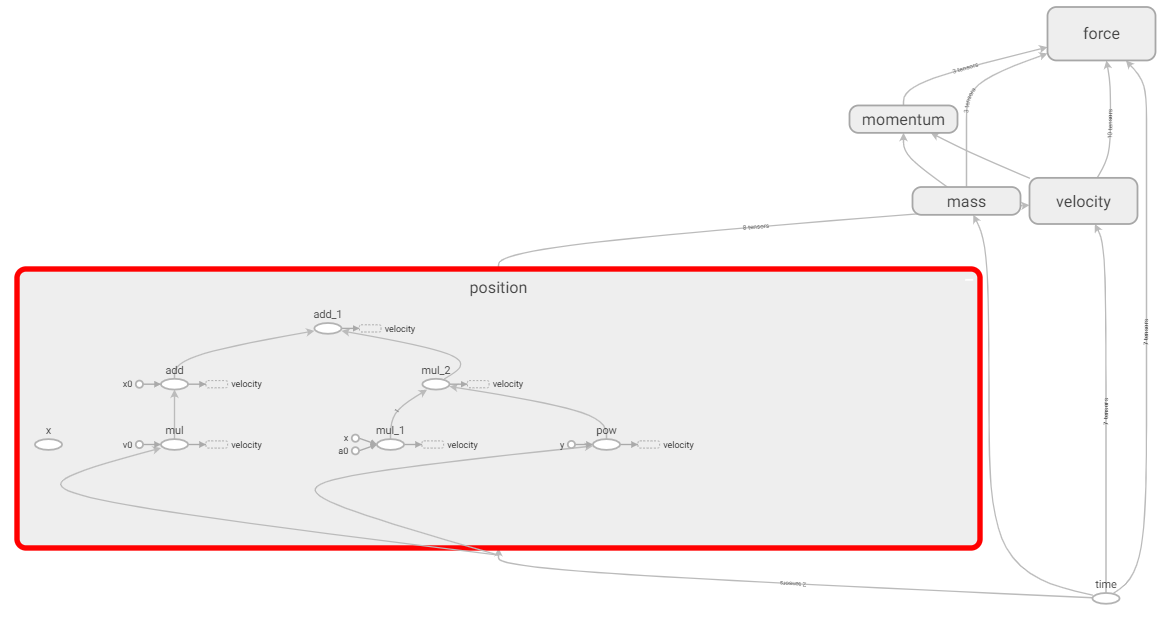

However, if we have partial knowledge that _position is time-varying_, then we might want to use a data-driven model to change incomplete knowledge to model uncertainty. In this example we define a neural network to capture that position is an unknown function of time

In [5]:
def neural_network(X, W, b):
    h = X
    for ii in range(len(W)-1):
        h = tf.nn.relu(tf.matmul(h, W[ii]) + b[ii])

    h = tf.matmul(h, W[-1]) + b[-1]
    return tf.reshape(h, [-1]) 

In [6]:
mdl4 = tf.Graph()
with mdl4.as_default():
    t = tf.placeholder(tf.float32, name="time")
    
    with tf.name_scope("position") as scope:
        x = tf.placeholder(tf.float32, name="x")
        
        #the structure of neural_network is hard-coded
        W = []
        W.append(tf.Variable(tf.random_uniform([1,3]), name="W_1"))
        W.append(tf.Variable(tf.random_uniform([3,1]), name="W_2"))
        b = []
        b.append(tf.Variable(tf.random_uniform([3]), name="b_1"))
        b.append(tf.Variable(tf.random_uniform([1]), name="b_2"))
        
        x = neural_network(t, W, b)

    with tf.name_scope("mass", ["r0", "m0", "m"]) as scope:
        r0 = tf.constant([-0.001], name="r0")
        m0 = tf.constant([10.0], name="m0")
        m = tf.placeholder(tf.float32, name="mass")
        m = m0 + r0*t

    v = tf.gradients(x, [t], stop_gradients=[t], name="velocity")
    P = tf.multiply(m,v, name="momentum")
    F = tf.gradients(P, [t], stop_gradients=[t], name="force")

# Intialize the Session
with tf.Session(graph=mdl4) as sess:    
    # Initialize writer
    writer = tf.summary.FileWriter("./log/example/4", sess.graph)
    # Close the writer
    writer.close()

The computational graph depicted by the above code as visualized by TensorBoard is as follows:

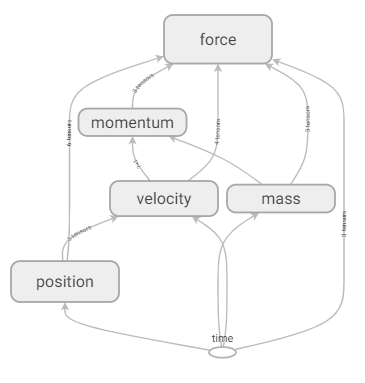

Note that the figure is this level is similar, but the hierarchical graph under position has a neural network instead of the physics-based equation of example 3 as shown below:

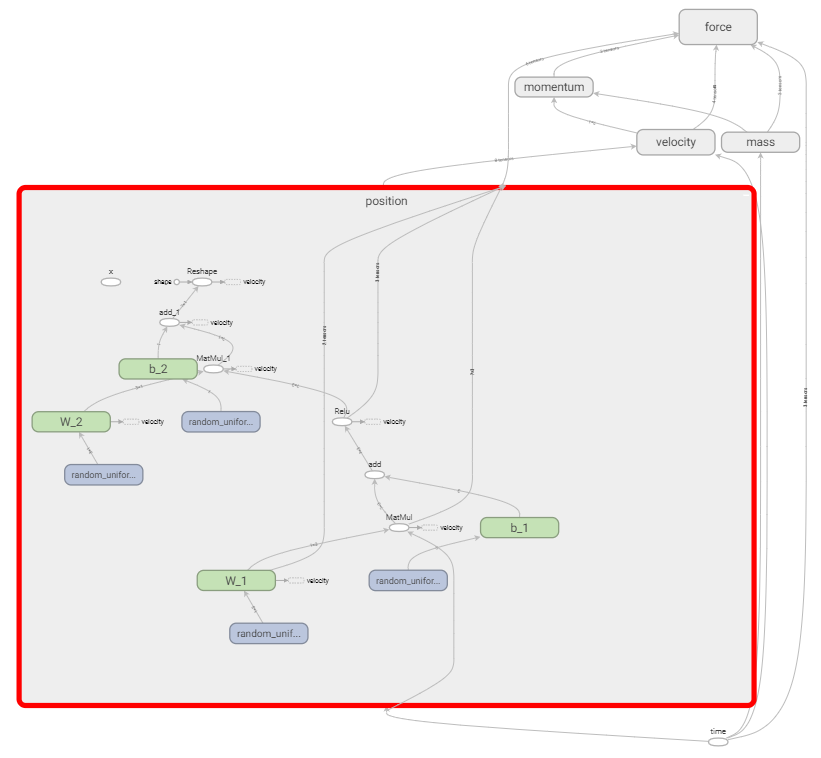



This shows modularity and that the graph can be refined locally to include hybrid models

### References:

TensorFlow gradients <br>
https://www.tensorflow.org/api_docs/python/tf/gradients